<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [4.2 State Estimation](https://jckantor.github.io/cbe30338-2021/04.02-State-Estimation.html) | [Contents](toc.html) | [4.4 Anomaly Detection](https://jckantor.github.io/cbe30338-2021/04.04-Anomaly-Detection.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/04.03-Lab-Assigment-State-Estimation.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/04.03-Lab-Assigment-State-Estimation.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 4.3 Lab Assignment 5: State Estimation

Using the notes for Secion 4.2, the goal of this lab assignment is to build a state estimator for the Temperature Control Laboratory, then use it to achieve independent control of the two heater temperatures. The project will require updating the four state model you developed for Lab Assignment 2 described in Section 2.4.

### 4.3.1 Step 1. Estimate model parameters

Refer to exercise 3 from Lab Assignment 2. Write our the four state model of the Temperature Control Lab. If needed, perform the experiment described in the assignment to gather the data needed to fit all model parameters. Report the parameter values.

In [1]:
# Run experiment to generate new data to fit parameters

Text(0, 0.5, '% Max Power')

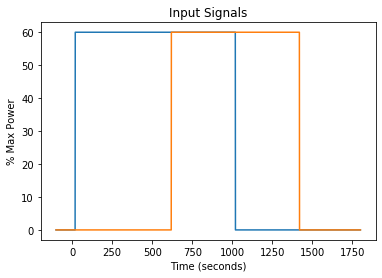

In [2]:
# Exercise 1
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Define functions for u1(t) and u2(t) (using interpolation) that create the input signals

t1_expt = [20,20,1020,1020]

u1_expt = [0,60,60,0]

t2_expt = [620,620,1420,1420]

u2_expt = [0,60,60,0]

def u1(t):
    return np.interp(t, t1_expt, u1_expt)

def u2(t):
    return np.interp(t, t2_expt, u2_expt)

time=np.linspace(-100,1800,1901)

plt.plot(time,u1(time))
plt.plot(time,u2(time))
plt.title('Input Signals')
plt.xlabel('Time (seconds)')
plt.ylabel('% Max Power')

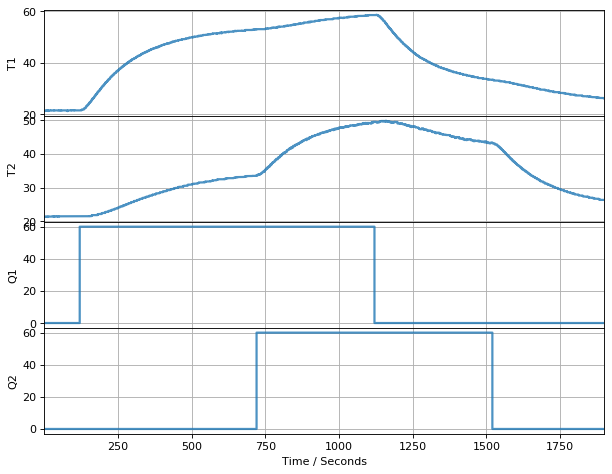

TCLab disconnected successfully.


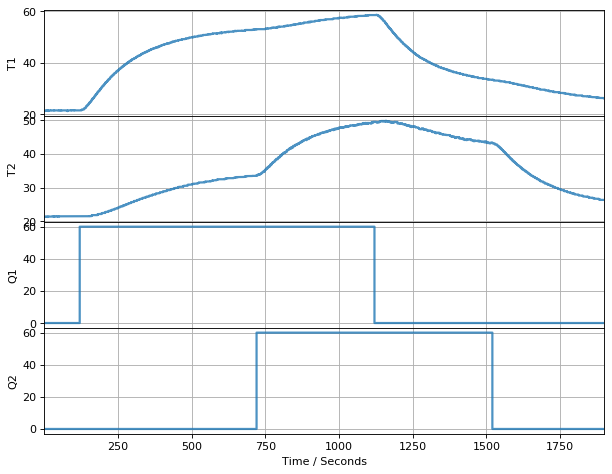

In [3]:
%matplotlib inline

from tclab import TCLab, clock, Historian, Plotter

with TCLab() as lab:
    lab.P1=200
    lab.P2=100
    h = Historian(lab.sources)
    p = Plotter(h, 1900)
    for t in clock(1900):
        x=t-100 
        lab.Q1(0 if t<=100 else u1(x))
        lab.Q2(0 if t<=100 else u2(x))
        p.update(t)
   
        
# save the data
h.to_csv('data_lab5.csv')

,T1,T2,Q1,Q2
Time,,,,
0.00,21.253,21.285,0.0,0.0
2.00,21.543,21.350,0.0,0.0
4.00,21.543,21.446,0.0,0.0
6.01,21.543,21.350,0.0,0.0
8.00,21.382,21.382,0.0,0.0
...,...,...,...,...
1892.01,26.377,26.377,0.0,0.0
1894.01,26.377,26.377,0.0,0.0
1896.02,26.345,26.377,0.0,0.0


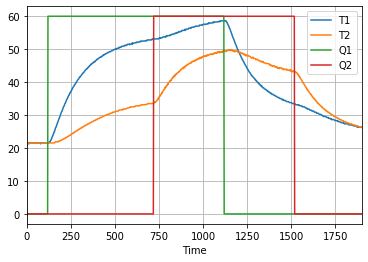

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

# read data file from the Github repository into a Pandas dataframe
data_location = "data_lab5.csv"
expt = pd.read_csv(data_location)

# set time index
expt = expt.set_index("Time")
t_expt = expt.index

# display data in tabular format
display(expt)

# simple plotting
expt.plot(grid=True)

In [13]:
# create a function to compare two data sets
def plot_data(expt, pred):
    t_expt = expt.index 
    
    # create a 3 x 1 grid of plot axes
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    
    # first plot axes
    ax[0].scatter(t_expt, expt["T1"], label="T1 expt")
    ax[0].scatter(t_expt, expt["T2"], label="T2 expt")
    ax[0].plot(t_expt, pred["T1"], label="T1 pred")
    ax[0].plot(t_expt, pred["T2"], label="T2 pred")
    ax[0].set_ylabel("deg C")
    ax[0].set_title("temperature response")

    # second plot axes
    ax[1].scatter(t_expt, expt["Q1"], label="Q1 expt")
    ax[1].scatter(t_expt, expt["Q2"], label="Q2 expt")
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].plot(t_expt, pred["Q2"], label="Q2 pred")
    ax[1].set_ylim([0, 100])
    ax[1].set_ylabel("percent")
    ax[1].set_title("heater power")
    
    # third plot axes
    ax[2].plot(t_expt, pred["T1"]-expt["T1"], label="T1 error")
    ax[2].plot(t_expt, pred["T2"]-expt["T2"], label="T1 error")
    ax[2].set_title("residuals")
    
    # things to do for every plot axes
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    
    return
    

array([ 0.747     ,  0.457     ,  0.457     , ..., -2.24085652,
       -2.26180328, -2.28290798])

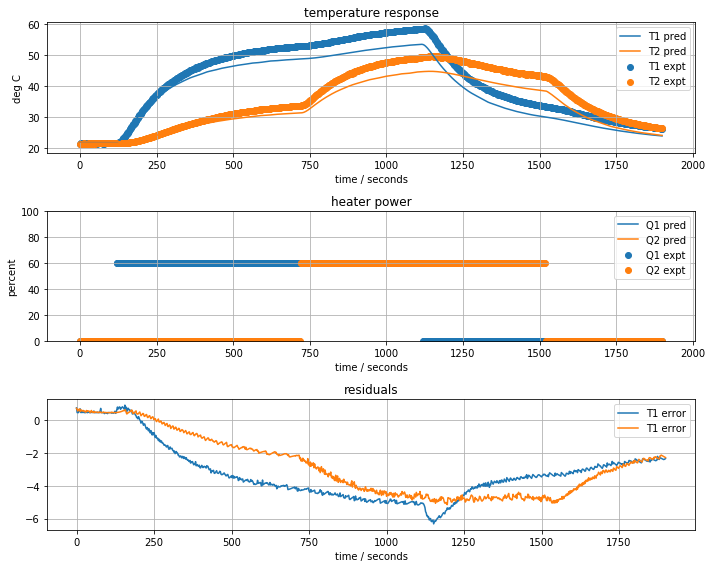

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

t_expt = expt.index 

# Set parameter values
alpha = 0.00016        # watts / (units P1 * percent U1)
P1=200
P2=100
T_amb = 22

# adjustable parameters
CpH = 8                # joules/deg C
CpS = 2                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.1               # watts/deg C
Uc = 0.03              # watts/deg C


def model_state_space(param, plot=False):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub, Uc = param  
    
    A = np.array([
        [-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0],
        [Ub/CpS, -Ub/CpS, 0, 0],
        [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
        [0, 0, Ub/CpS, -Ub/CpS]
    ])
    Bu = np.array([
        [alpha*P1/CpH, 0],
        [0, 0],
        [0, alpha*P2/CpH],
        [0, 0]
    ])
    Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])
    C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])
    
    # model solution
    def deriv(t, y):
        x=t-100 
        u = np.array([0 if t<=100 else u1(x), 0 if t<=100 else u2(x)])
        d = np.array([T_amb])
        return np.dot(A, y) + np.dot(Bu, u) + np.dot(Bd, d)

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb]*4, t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[1]
    pred["T2"] = soln.y[3]
    
    # plot solution
    if plot:
        ax = plot_data(expt, pred)
    
    err1 = np.array(pred["T1"] - expt["T1"])
    err2 = np.array(pred["T2"] - expt["T2"])
    
    return np.concatenate((err1, err2))
    
model_state_space([CpH, CpS, Ua, Ub, Uc], plot=True)

CpH = 8.237372911073447,  CpS = 1.636003499128253,   Ua = 0.040814381592207884,  Ub = 0.09529165102405508,  Uc = 0.02938671300261787


array([ 0.747     ,  0.457     ,  0.457     , ..., -0.65561085,
       -0.68089039, -0.70636583])

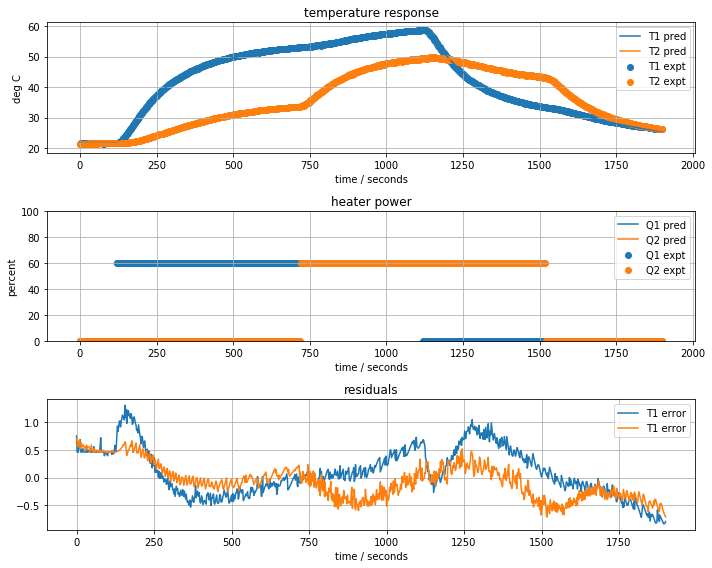

In [17]:
results = least_squares(model_state_space,  [CpH, CpS, Ua, Ub, Uc])
CpH, CpS, Ua, Ub, Uc = results.x
print(f"CpH = {CpH},  CpS = {CpS},   Ua = {Ua},  Ub = {Ub},  Uc = {Uc}")
model_state_space(results.x, True)

In [24]:
# Report the parameter values.

print('The least-squares fit value for CpH is',round(CpH,3),'(J/deg C).')
print('The least-squares fit value for CpS is',round(CpS,4),'(J/deg C).')
print('The least-squares fit value for Ua is',round(Ua,4),'.')
print('The least-squares fit value for Ub is',round(Ub,4),'.')
print('The least-squares fit value for Uc is',round(Uc,4),'.')


The least-squares fit value for CpH is 8.237 (J/deg C).
The least-squares fit value for CpS is 1.636 (J/deg C).
The least-squares fit value for Ua is 0.0408 .
The least-squares fit value for Ub is 0.0953 .
The least-squares fit value for Uc is 0.0294 .


### 4.3.2 Step 2. Create state-space model

Using the matrix and vector formulation described in notebook 4.2, rewrite the equations for the four state model in state-space form. In a new python notebook, use the parameter values from Step 1 to numerically evaluate matrices $A$, $B_u$, $B_d$ and $d$.  Compute the eigenvalues (they should all be negative real numbers) of $A$ and report the negative inverse of the eigenvalues as time constants. 

### 4.3.3 Step 3. Implement a state estimator 

Implement a state estimate utilizing measurements T1 and T2, and inputs Q1 and Q2, to estimate the state. As an initial choice for matrix $L$ use

$$L = \begin{bmatrix} 0.4 & 0 \\ 0.2 & 0 \\ 0 & 0.4 \\ 0 & 0.2 \end{bmatrix}$$

### 4.3.4 Step 4. Implement relay control for the heater temperatures T1H and T2H

Using constant setpoints of 45 and 40 degrees, respectively, for temperatures $T_{1}$ and $T_{2}$. At time t = 300, have the setpoints switch to 40 and 45 degrees, respectiviely. Show control performance over total of 600 seconds when using sensor measurements for relay control.  Replace the sensor measurements with observer estimates for heater temperatures $T_{H,1}$ and $T_{H,2}$ and repeat the test. What do you observe?

<!--NAVIGATION-->
< [4.2 State Estimation](https://jckantor.github.io/cbe30338-2021/04.02-State-Estimation.html) | [Contents](toc.html) | [4.4 Anomaly Detection](https://jckantor.github.io/cbe30338-2021/04.04-Anomaly-Detection.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/04.03-Lab-Assigment-State-Estimation.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/04.03-Lab-Assigment-State-Estimation.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>